# Data Visualization Analyisis

## Data Loading

In [97]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean, log1p, UserDefinedFunction, explode, rand, when, lit, count
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": user, "password": password}


df_caract = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dog_caract_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", driver_class) \
    .load()


df_caract.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|               Breed|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|      1|          1|       0|     0|                 3|                   3|                  0|       0|    Ameri

In [98]:
df_caract2 = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dog_caract2_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", driver_class) \
    .load()

df_caract2.show()

+--------------------+------------+---+--------------------+--------------------+
|            bred_for| breed_group| id|               Breed|         temperament|
+--------------------+------------+---+--------------------+--------------------+
|Small rodent hunt...|         Toy|  1|       Affenpinscher|Stubborn, Curious...|
|Coursing and hunting|       Hound|  2|        Afghan Hound|Aloof, Clownish, ...|
|  A wild pack animal|     Working|  3| African Hunting Dog|Wild, Hardworking...|
|Badger, otter hun...|     Terrier|  4|    Airedale Terrier|Outgoing, Friendl...|
|      Sheep guarding|     Working|  5|          Akbash Dog|Loyal, Independen...|
|       Hunting bears|     Working|  6|               Akita|Docile, Alert, Re...|
|            Guarding|       Mixed|  7|Alapaha Blue Bloo...|Loving, Protectiv...|
|        Sled pulling|       Mixed|  8|       Alaskan Husky|Friendly, Energet...|
|Hauling heavy fre...|     Working|  9|    Alaskan Malamute|Friendly, Affecti...|
|              L

### Explotation zone for dog_caract2

In [99]:
from pyspark.sql.functions import split, explode

# Tenim una columna que té una llista de valors en una string
# Volem passar-la a columnes dummy

# Identifiquem totes les categories diferents dins de temperament
unique_categories = df_caract2.select(explode(split(df_caract2["temperament"], ",\s*")).alias("temperament")).distinct()

# Creem les columnes dummy
for category_row in unique_categories.collect():
    category = category_row["temperament"]
    df_caract2 = df_caract2.withColumn(category, df_caract2["temperament"].contains(category).cast("int"))

df_caract2 = df_caract2.drop(*["id", "temperament", "bred_for"])

df_caract2.show()

+------------+--------------------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+----+------+---------------+--------+--------+-----+-------+------+------+---------+-------+----------+--------+------------+--------+------+---------------+----------+--------+---------+----------+-------+----+---------+------------+-------------+----------+------+--------+-------+-----------+-----+--------+

In [100]:
df_intel = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bda_p1") \
    .option("dbtable", "dog_intelligence_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_intel.show()

+--------------------+--------------------+----+--------+
|               Breed|      Classification|obey|avg_reps|
+--------------------+--------------------+----+--------+
|       Border Collie|      Brightest Dogs|  95|     2.5|
|              Poodle|      Brightest Dogs|  95|     2.5|
|     German Shepherd|      Brightest Dogs|  95|     2.5|
|    Golden Retriever|      Brightest Dogs|  95|     2.5|
|   Doberman Pinscher|      Brightest Dogs|  95|     2.5|
|   Shetland Sheepdog|      Brightest Dogs|  95|     2.5|
|  Labrador Retriever|      Brightest Dogs|  95|     2.5|
|            Papillon|      Brightest Dogs|  95|     2.5|
|          Rottweiler|      Brightest Dogs|  95|     2.5|
|Australian Cattle...|      Brightest Dogs|  95|     2.5|
|Pembroke Welsh Corgi|Excellent Working...|  85|    10.0|
| Miniature Schnauzer|Excellent Working...|  85|    10.0|
|English Springer ...|Excellent Working...|  85|    10.0|
|Belgian Shepherd ...|Excellent Working...|  85|    10.0|
|          Sch

## Table Join

In [101]:
df = df_caract.join(df_intel, 
               df_caract.Breed == df_intel.Breed, 
               "inner").drop(df_intel.Breed) # Drop allows to remove duplicates
df = df.join(df_caract2, 
               df.Breed == df_caract2.Breed, 
               "inner").drop(df_caract2.Breed) # Drop allows to remove duplicates
df = df.distinct()

print(df.count())
df.show()

92
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+------------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+

# Univariant Analysis

In [102]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Numerical Variables Visualization

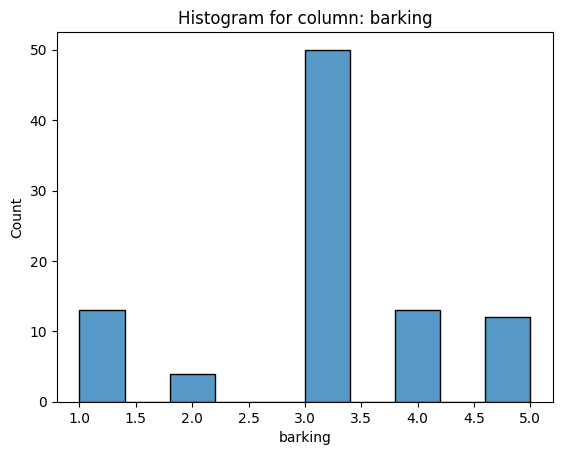

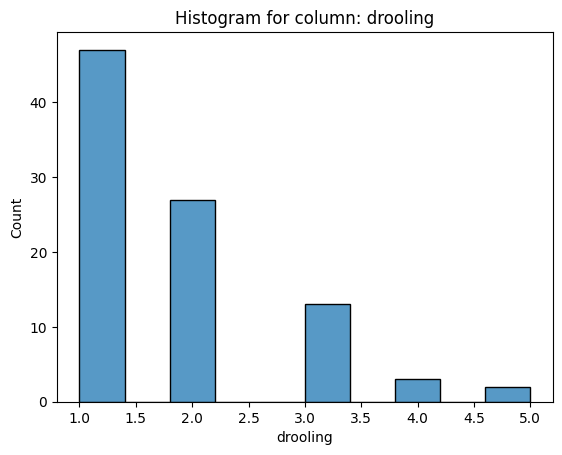

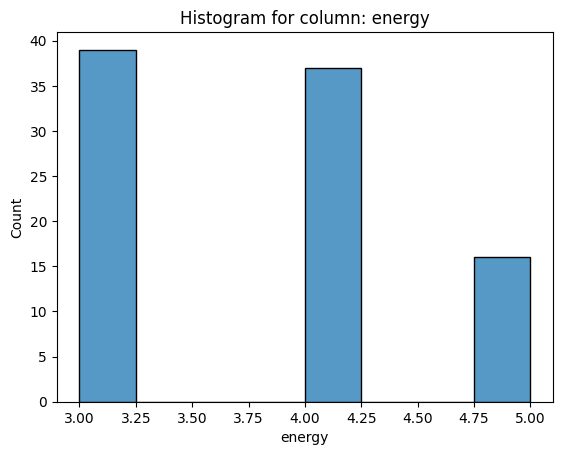

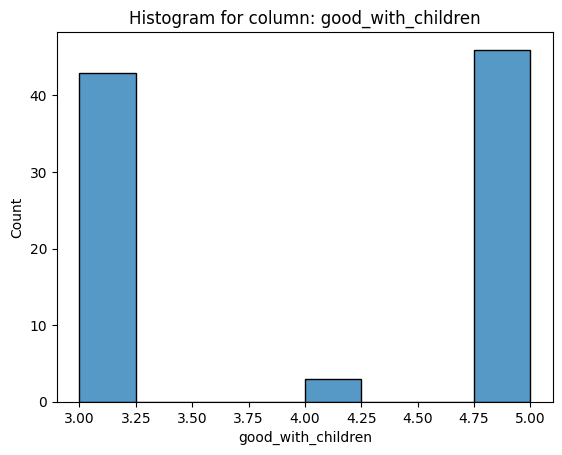

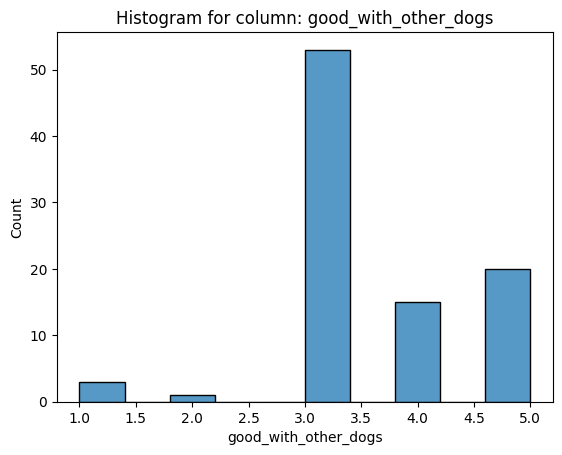

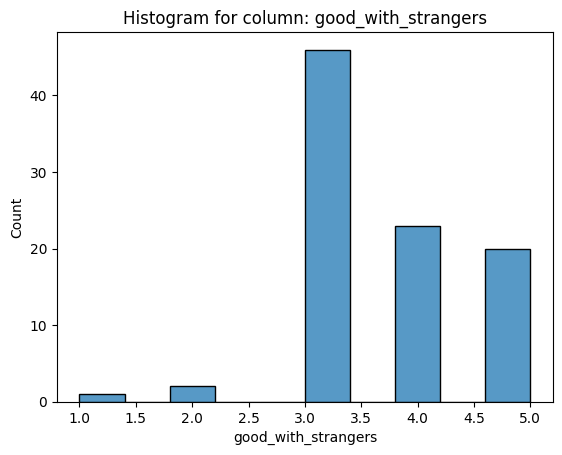

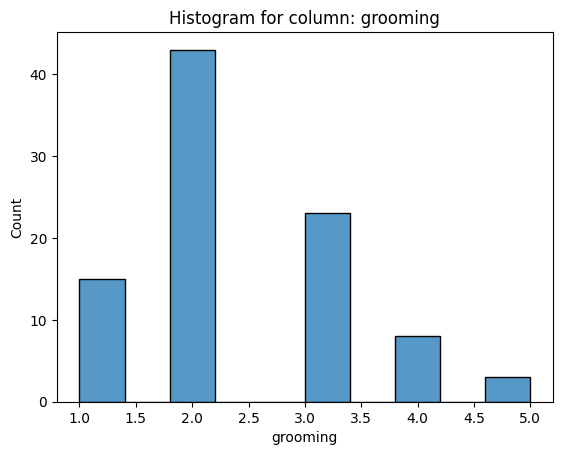

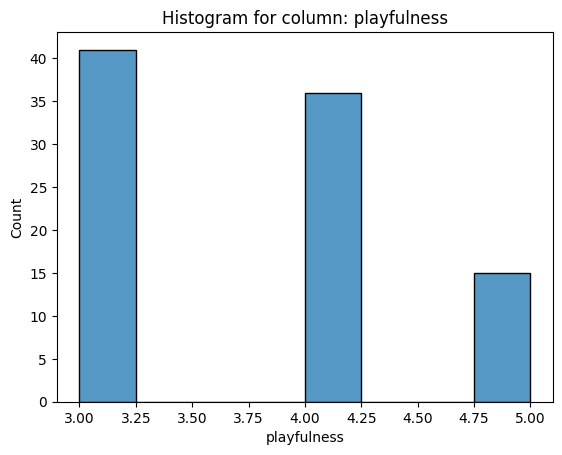

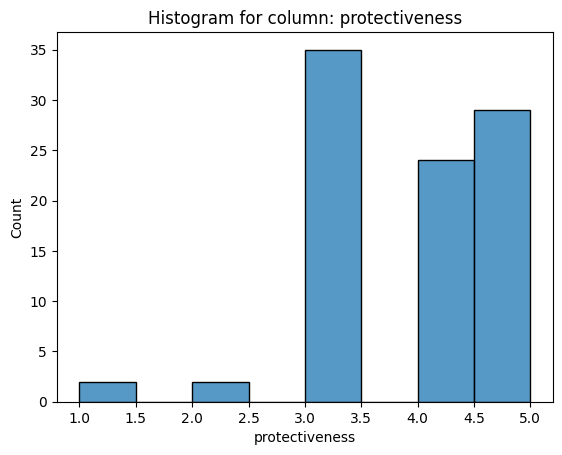

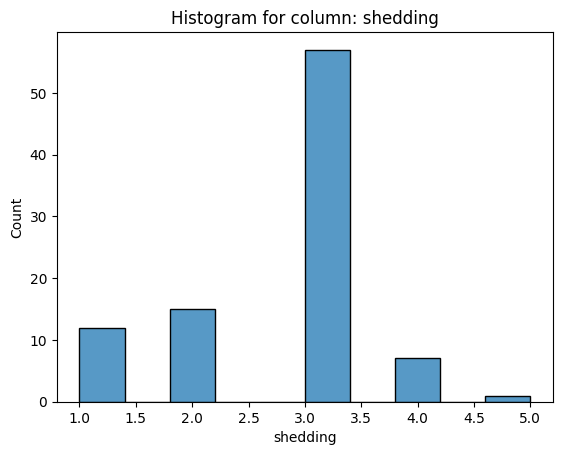

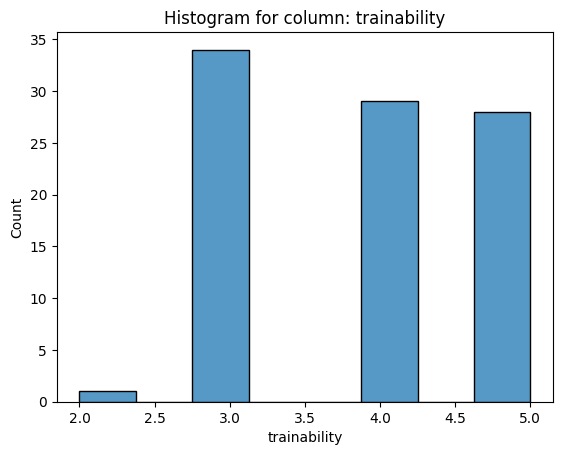

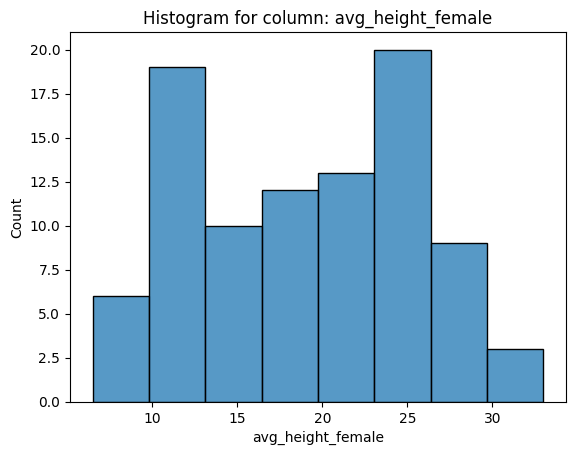

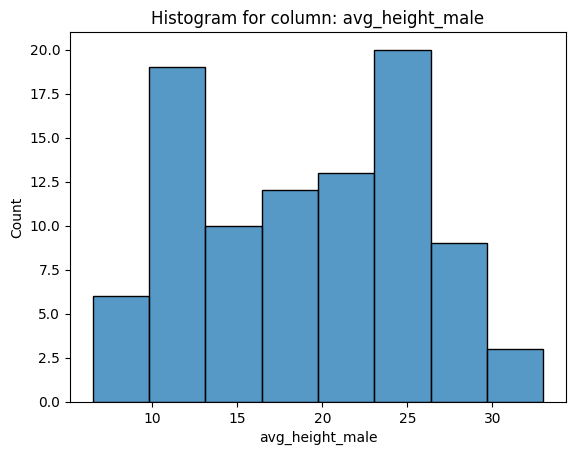

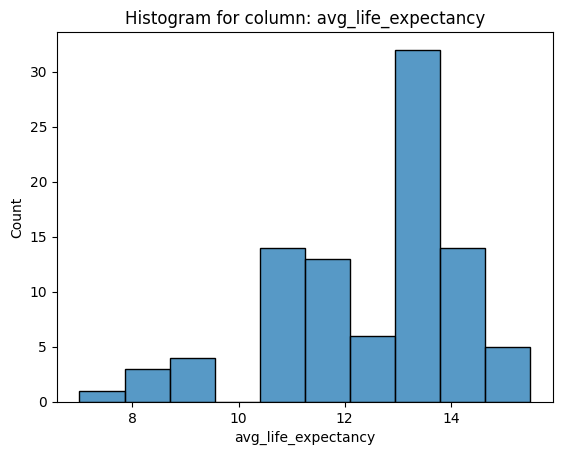

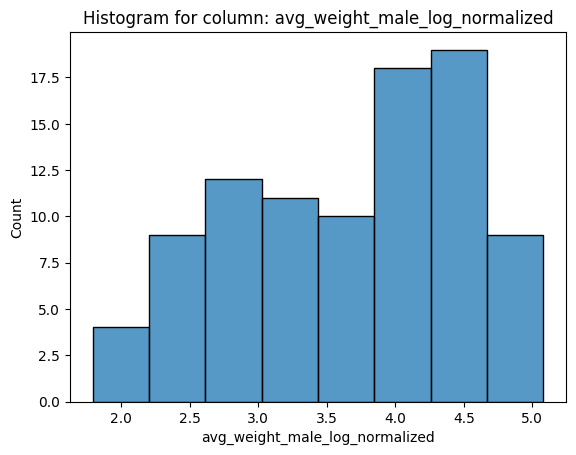

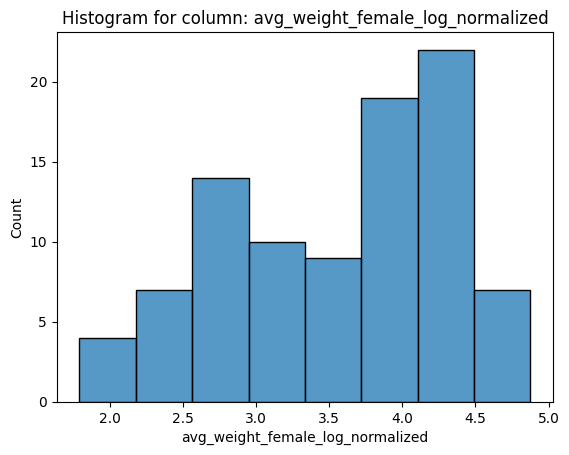

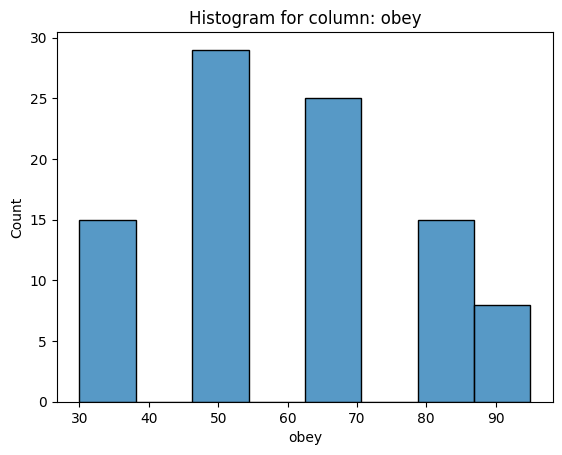

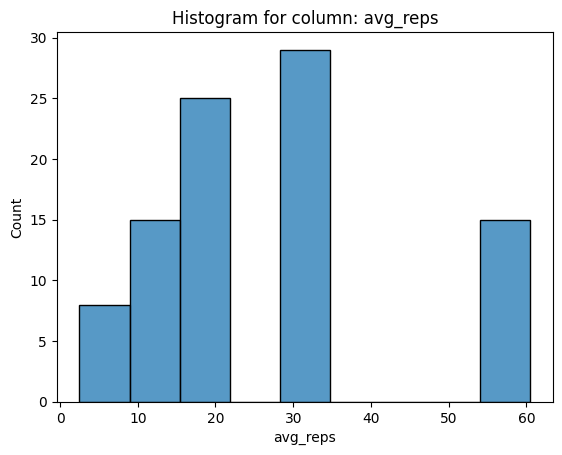

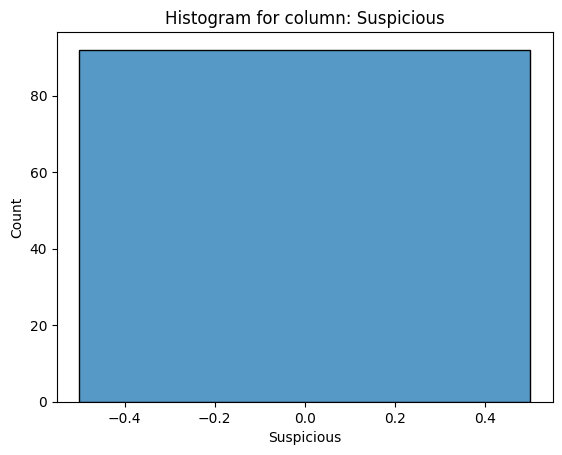

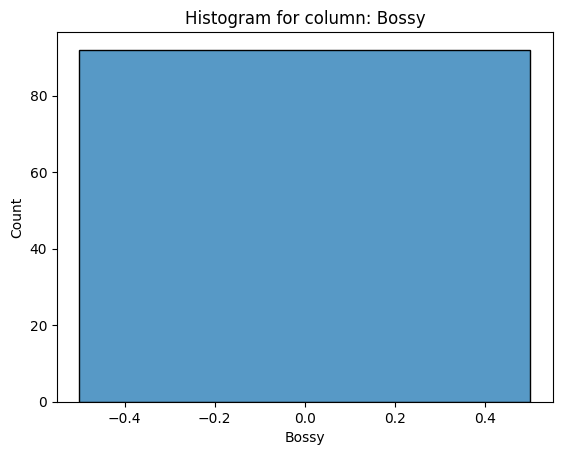

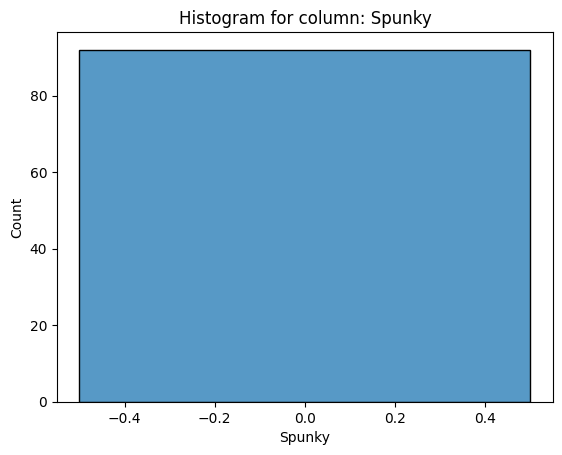

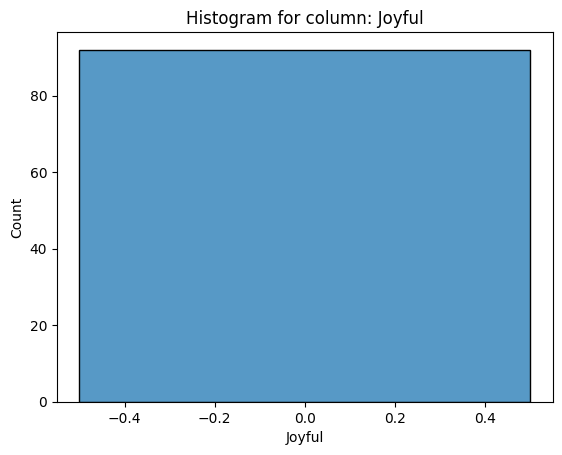

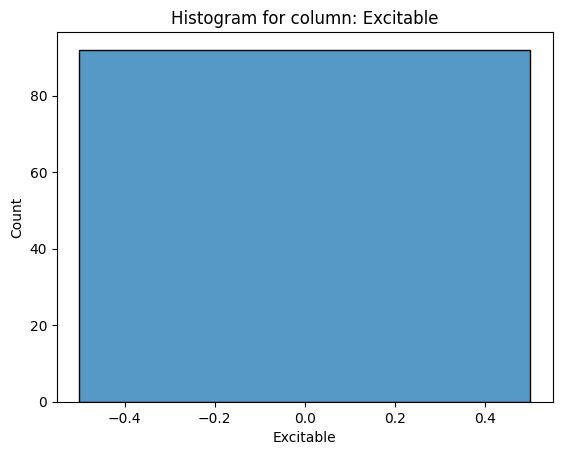

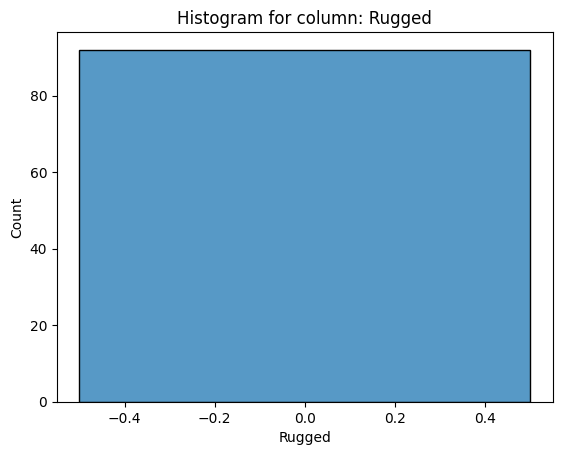

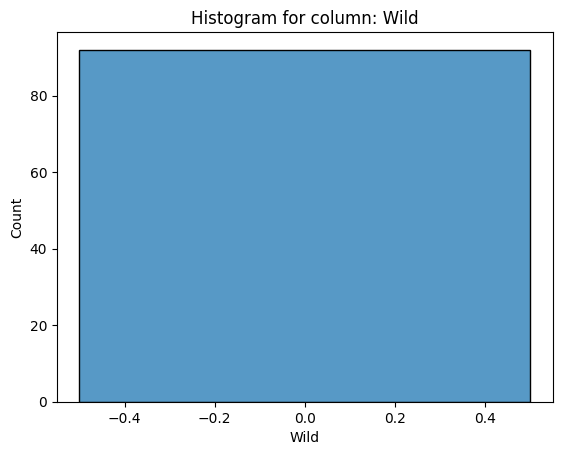

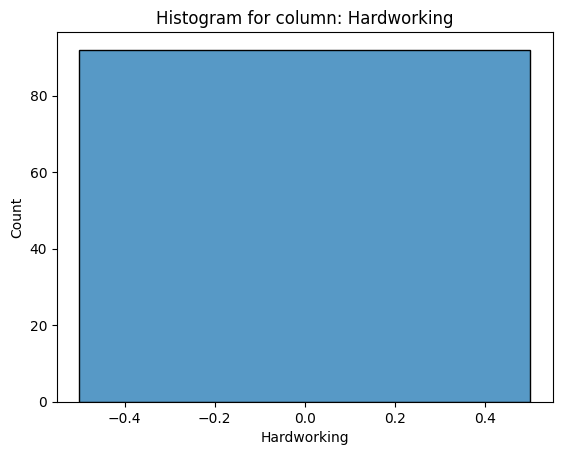

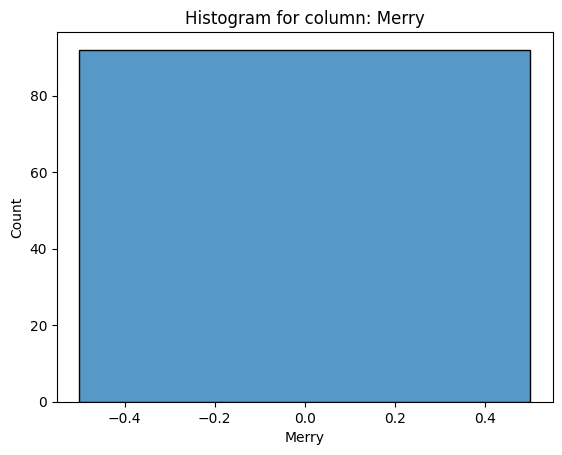

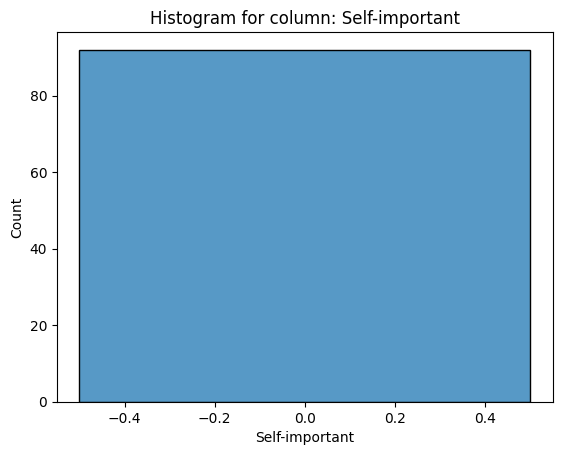

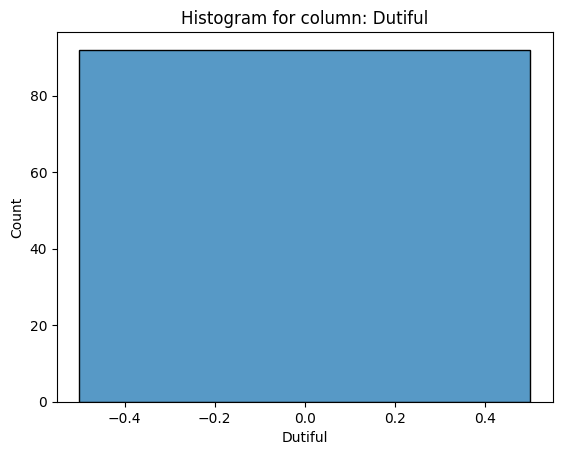

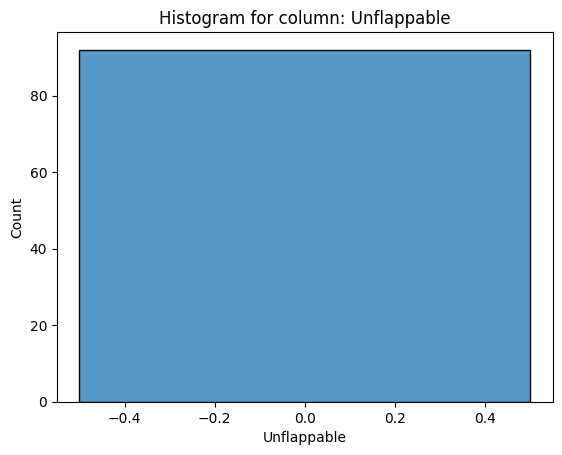

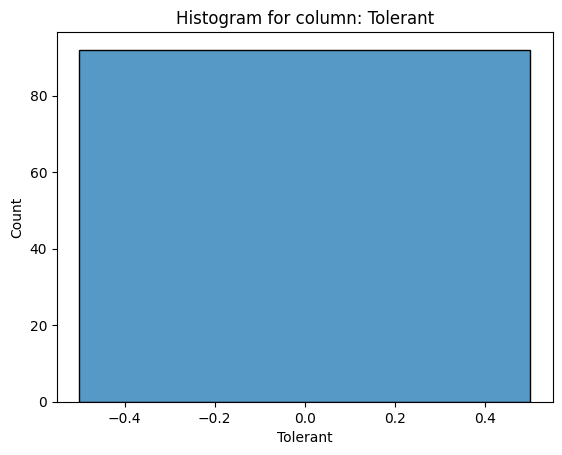

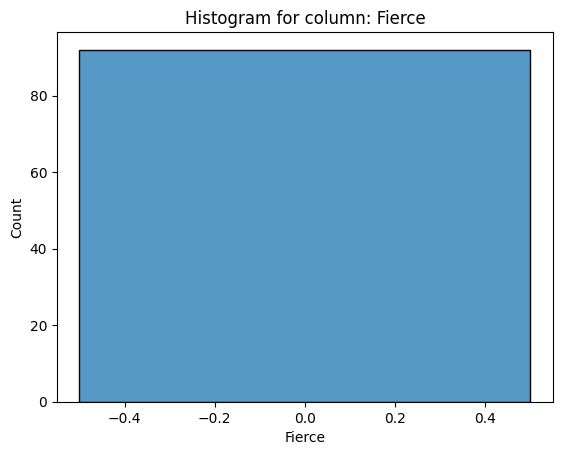

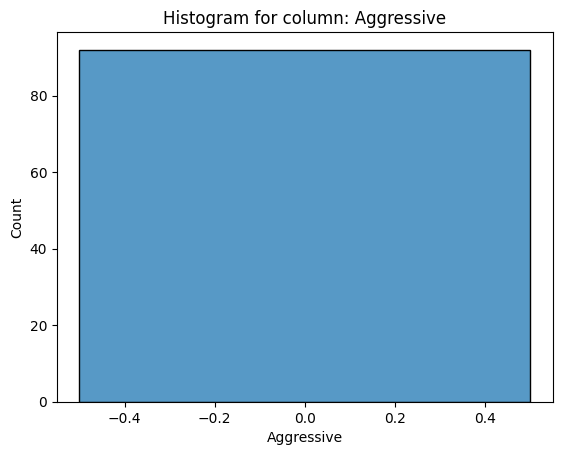

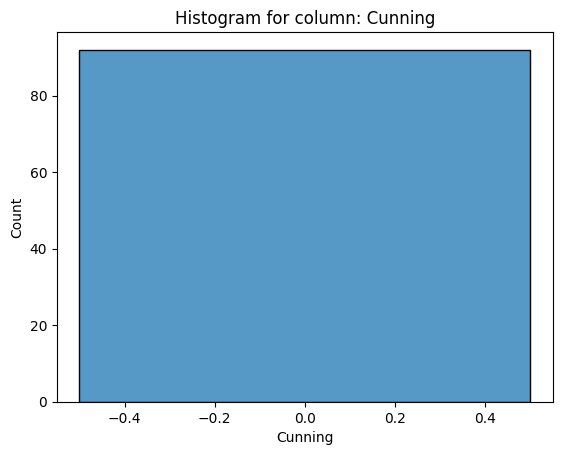

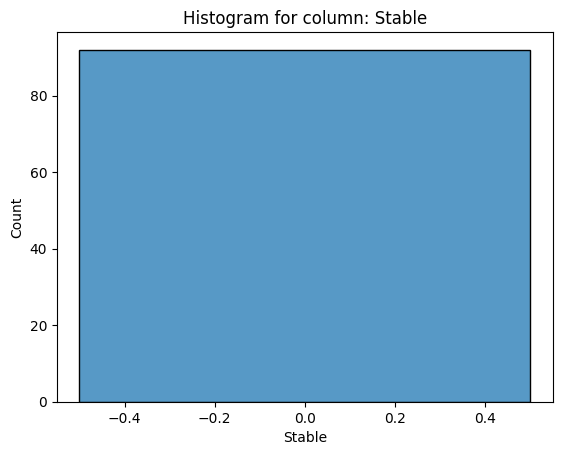

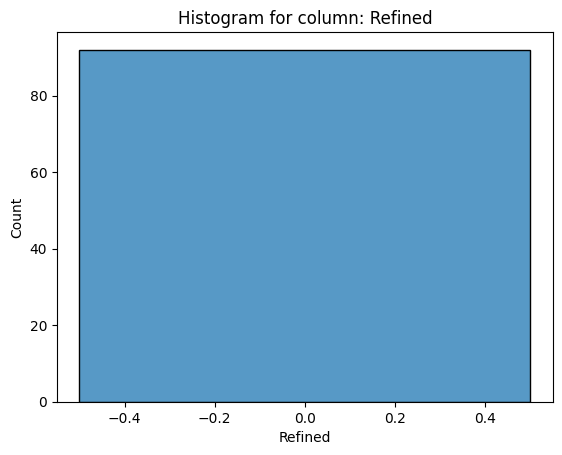

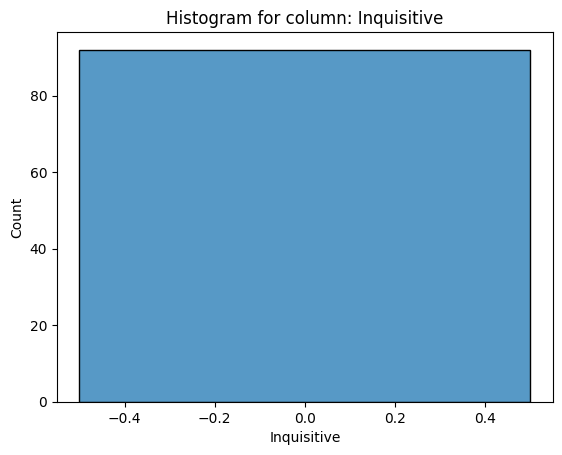

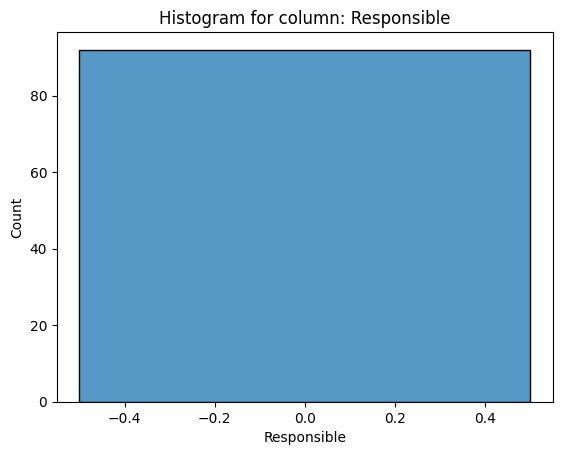

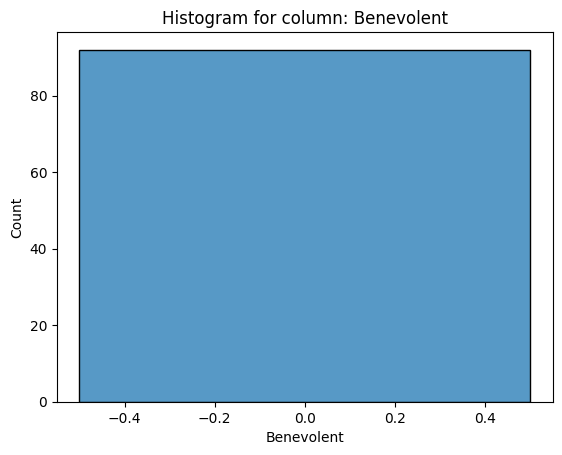

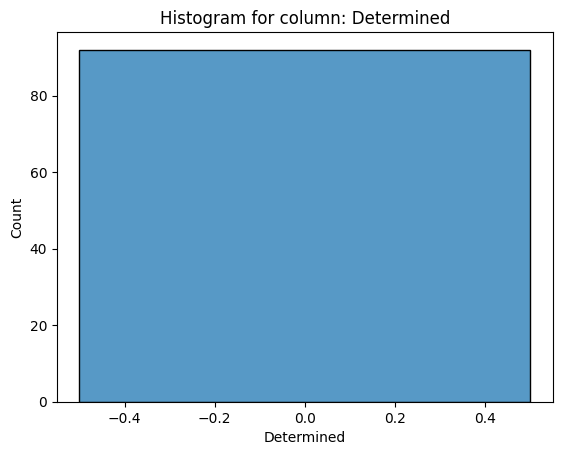

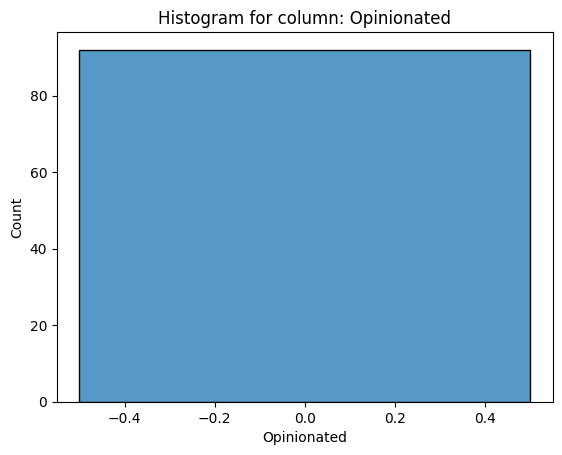

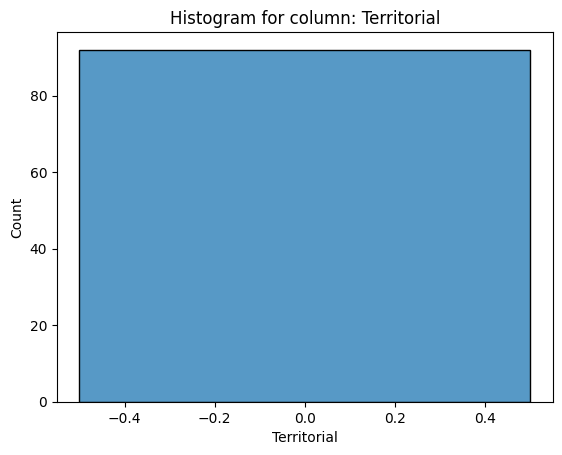

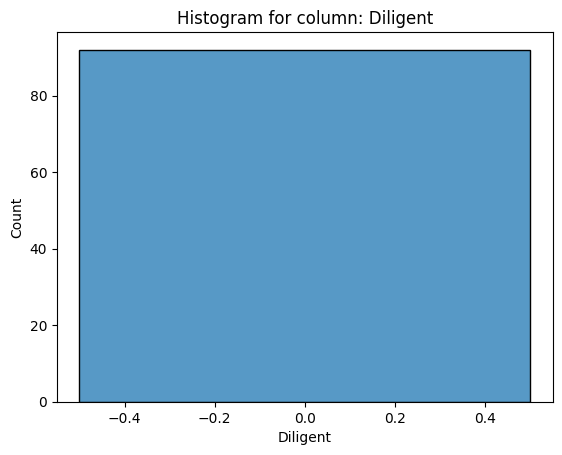

In [103]:
dummies = [column for column in df.columns if df.select(column).distinct().count() == 2]

numeric_variables = [column for column, dtype in df.dtypes if dtype in ["int", "double", "bigint"] and column not in dummies]
for num_col in numeric_variables:
  df_pandas = df.toPandas()
  sns.histplot(data=df_pandas, x=num_col)
  plt.title(f"Histogram for column: {num_col}")
  plt.show()

Anàlisis de les variables:
- Barking: Veiem com el rang va de 1 a 5, sent 3 el valor més alt, però trobem que hi ha més races que borden molt a que borden poc.
- Coat length: Veiem com la majoria de races tenen el pèl curt, però n'hi ha algun que el té més llarg, i que es representa amb un 2.
- Drooling: Veiem com els gossos bavejen, però a mesura que augmenta el nivell de baveig, la quantitat de races que hi ha es va reduint de manera força estable.
- Energy: Pel que fa a l'energia, trobem que el rang és de 3 a 5, i que la moda està al quatre, sent el 3 el més popular i el 5 el que menys, però tampoc es queda massa curt. Veiem com totes les races de gossos presents en les dades tenen energia, però no n'hi ha tants que tinguin el nivell més alt.
- Good with children: De nou, el rang es troba entre 3 i 5, sent 3 i 5 els més populars, guanyant el 5 per ben poc, i en el nivell 4 hi ha molt poques races. Això ens mostra que els gossos mai són súper dolents amb els infants, però tenim una clara polarització entre si no son gaire bons o si són boníssims.
- Good_with_other_dogs: En aquest cas sí que trobem que hi ha instàncies del nivell més baix, tot i que mantenim el 3 com a moda i el 5 i el quatre que els segueixen, sent el nivell 1 i el 2 força minoritaris. Això mostra que en general els gossos també són bons amb altres gossos.
- Good_with_strangers: En aquesta variable veiem una distribució similar a la anterior però el nivell 4 és més popular que el 5. Per tant, en general també són bons amb desconeguts.
- Grooming: Pel que fa a si van bé per a netejar-los o tallar-lis el pèl, veiem com la moda és al centre, però la majoria no van bé, escepte una minoria que sí 
- Playfulness: Tots són juganers, però la moda és el 3, sent el 4 i el 5 una mica menys representats però tampoc tant poc. 
- Protectiveness: La majoria són protectors (van ser entrenats durant segles per això), estant entre 3 i 5, i sent el 1 i el 2 minoritaris però no inexistents.
- Shedding: La majoria de gossos ni deixen molt de pèl ni en deixen poc, estàn al centre (3), tot i així, veiem una distribució normal cap a les dues bandes, sent el 2 i el 4 els següents més populars i als extrems hi ha menys races, tot i que hi ha més races que deixen poc pèl que les que en deixen molt. 
- Trainability: La majoria són facils d'entrenar, sent el 3 el valor més popular, seguit del 4 i després el 5 de ben a prop. Tenim algun 2 minoritari.
- Pel que fa a l'alçada, no veiem diferències entre la dels mascles i les famelles, ja que comparteixen la mateixa distribució en el mateix rang.
- Pel que fa a l'esperança de vida, la majoria es troben al voltant dels 13 anys, però hi ha gossos que no tenen més de 7 anys d'esperança.
- Pel que fa a si són obedients o no, veiem com una distribució força normal centrada en 50%, però aquest valor pot arribar fins a més del 90% o fins al 30%.

## Categorical Variables Visualization

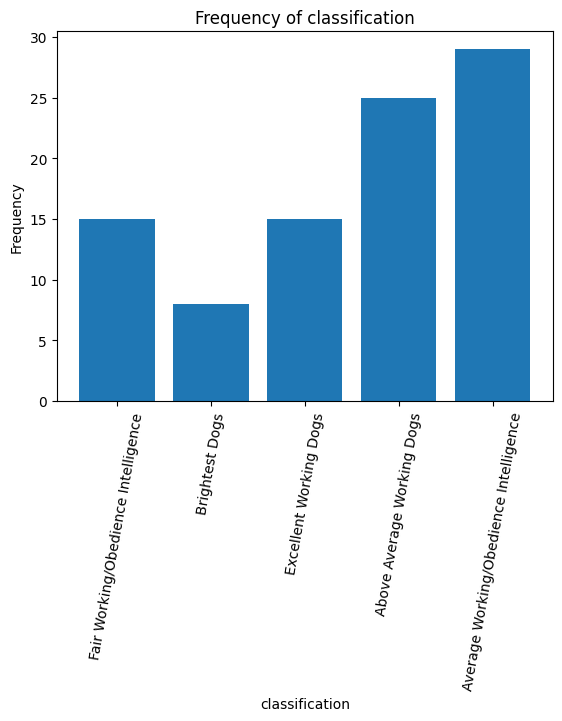

In [104]:
df_pandas = df.toPandas()

selected_column = "classification"

frequency_counts = df.groupBy(selected_column).agg(count(col(selected_column)).alias("count"))

frequency_counts_pandas = frequency_counts.toPandas()

plt.xticks(rotation=80)
plt.bar(frequency_counts_pandas[selected_column], frequency_counts_pandas["count"])
plt.xlabel(selected_column)
plt.ylabel("Frequency")
plt.title(f"Frequency of {selected_column}")
plt.show()


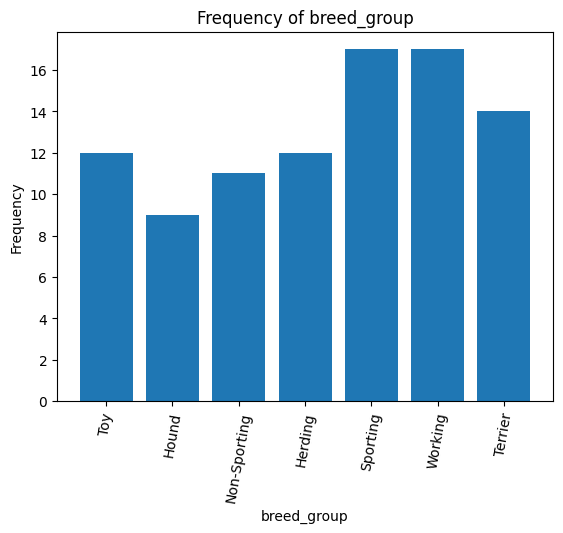

In [105]:
df_pandas = df.toPandas()

selected_column = "breed_group"

frequency_counts = df.groupBy(selected_column).agg(count(col(selected_column)).alias("count"))

frequency_counts_pandas = frequency_counts.toPandas()

plt.xticks(rotation=80)
plt.bar(frequency_counts_pandas[selected_column], frequency_counts_pandas["count"])
plt.xlabel(selected_column)
plt.ylabel("Frequency")
plt.title(f"Frequency of {selected_column}")
plt.show()

# Bivariant Analysis

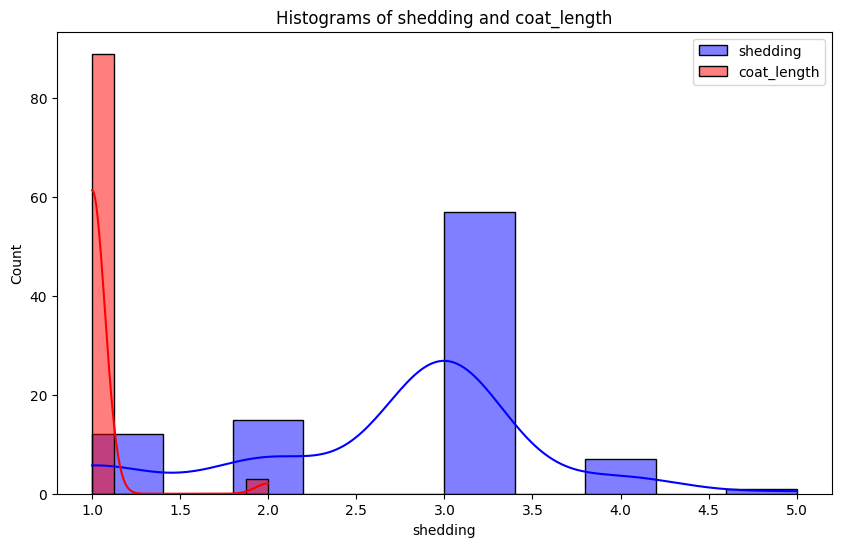

In [106]:
x_column = "shedding"
y_column = "coat_length"

df_pd = df.select(x_column, y_column).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_pd[x_column], kde=True, color='blue', label=x_column)
sns.histplot(df_pd[y_column], kde=True, color='red', label=y_column)
plt.title('Histograms of ' + x_column + ' and ' + y_column)
plt.legend()
plt.show()

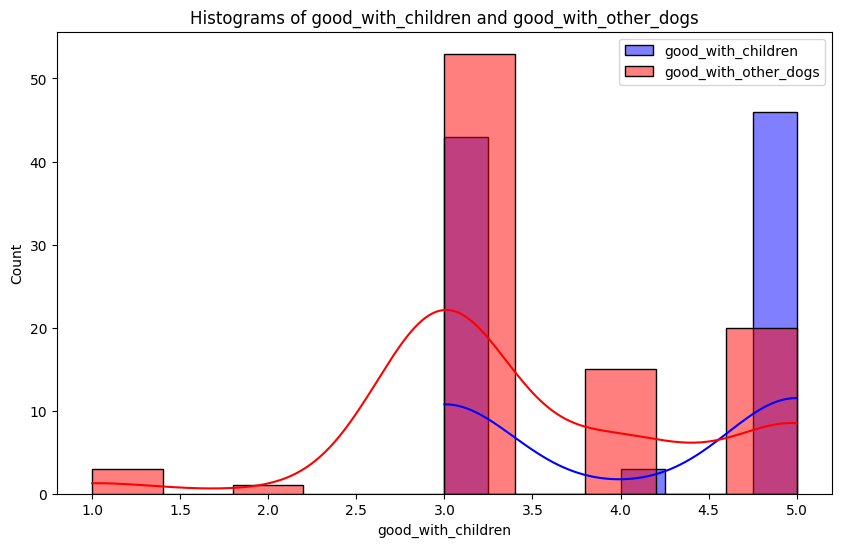

In [107]:
x_column = "good_with_children"
y_column = "good_with_other_dogs"

df_pd = df.select(x_column, y_column).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_pd[x_column], kde=True, color='blue', label=x_column)
sns.histplot(df_pd[y_column], kde=True, color='red', label=y_column)
plt.title('Histograms of ' + x_column + ' and ' + y_column)
plt.legend()
plt.show()

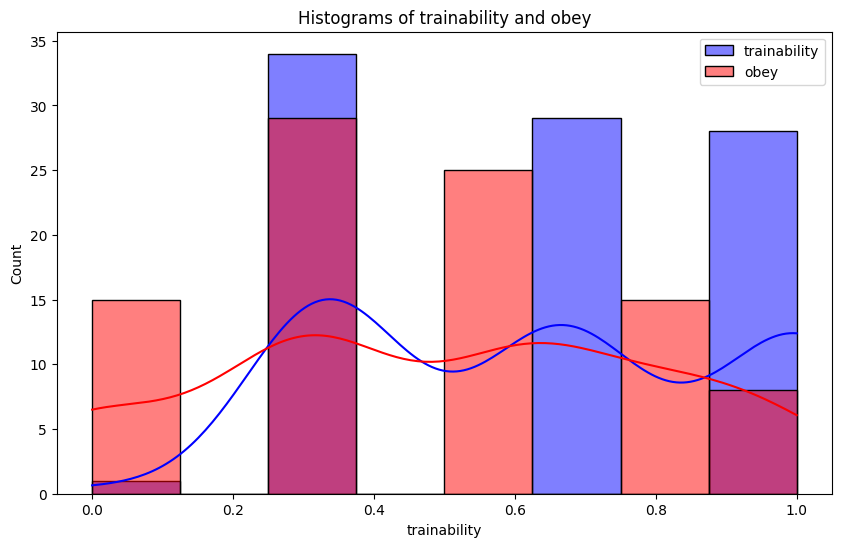

In [108]:
from sklearn.preprocessing import MinMaxScaler

x_column = "trainability"
y_column = "obey"

df_pd = df.select(x_column, y_column).toPandas()

scaler = MinMaxScaler()
df_pd[[x_column, y_column]] = scaler.fit_transform(df_pd[[x_column, y_column]])


plt.figure(figsize=(10, 6))
sns.histplot(df_pd[x_column], kde=True, color='blue', label=x_column)
sns.histplot(df_pd[y_column], kde=True, color='red', label=y_column)
plt.title('Histograms of ' + x_column + ' and ' + y_column)
plt.legend()
plt.show()

# Multivariant Analysis

## Clustering

In [109]:
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 

### Data preparation

In [110]:
# Dummy cols...
pivoted = df.groupBy("Breed").pivot("classification").agg(lit(1))
pivoted = pivoted.na.fill(0)
df = df.join(pivoted, 
               df.Breed == pivoted.Breed, 
               "inner").drop(pivoted.Breed) # Drop allows to remove duplicates
df = df.distinct()
print(df.count())
df.show()

92
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+------------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+----+------+---------

In [111]:
df = df.drop('Breed') # It does not make sense as there is one breed per row
df = df.drop('classification') # It does not make sense as we have it encoded now
df.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+----+--------+------------+------+--------+------+------+--------+----------+--------+--------+-----+--------+-----+--------+-----+---+-------------+-----+---------+----+------+---------+----+-----+-------------+--------+---------+------------+-----------+------+---------+---------+-------+-------------+------+--------+-------------+--------+-----+----+---------+------+----+--------------+----------+-----+-----------+--------+-----+------+--------------+-----+-------+--------+-------+----------+------+--------+------+-----------+--------+-----------+---------+-----+------+------+------------+--------+--------+-----------+-----------+-----------+--------+-----------+-------+----+------+---------------+--------+--------

In [112]:
df.columns

['barking',
 'coat_length',
 'drooling',
 'energy',
 'good_with_children',
 'good_with_other_dogs',
 'good_with_strangers',
 'grooming',
 'playfulness',
 'protectiveness',
 'shedding',
 'trainability',
 'avg_height_female',
 'avg_height_male',
 'avg_life_expectancy',
 'avg_weight_male_log_normalized',
 'avg_weight_female_log_normalized',
 'obey',
 'avg_reps',
 'breed_group',
 'Sturdy',
 'Outgoing',
 'Clever',
 'Steady',
 'Cheerful',
 'Suspicious',
 'Trusting',
 'Composed',
 'Eager',
 'Reliable',
 'Bossy',
 'Rational',
 'Brave',
 'Gay',
 'Even Tempered',
 'Hardy',
 'Attentive',
 'Calm',
 'Spunky',
 'Dignified',
 'Kind',
 'Loyal',
 'Great-hearted',
 'Vigilant',
 'Receptive',
 'Affectionate',
 'Trustworthy',
 'Joyful',
 'Excitable',
 'Assertive',
 'Playful',
 'Strong Willed',
 'Lively',
 'Reserved',
 'Good-tempered',
 'Spirited',
 'Quick',
 'Fast',
 'Energetic',
 'Rugged',
 'Wild',
 'Sweet-Tempered',
 'Thoughtful',
 'Aloof',
 'Hardworking',
 'Charming',
 'Merry',
 'Docile',
 'Self-importa

In [113]:
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
data_df = assembler.transform(df)

# Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)

IllegalArgumentException: Data type string of column breed_group is not supported.

In [ ]:
vec_assembler = VectorAssembler(inputCols = df.columns, 
                                outputCol='features') 
  
df = vec_assembler.transform(df) 
df.select('features').show(5)

IllegalArgumentException: Data type string of column bred_for is not supported.
Data type string of column breed_group is not supported.

In [ ]:
scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
  
# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(df) 
  
# Normalize each feature to have unit standard deviation. 
df_clustering = scalerModel.transform(df) 
  
df_clustering.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[2.65448442255625...|
|[2.65448442255625...|
|[1.76965628170416...|
|[2.65448442255625...|
|[4.42414070426042...|
+--------------------+
only showing top 5 rows



In [ ]:
null_counts = df_clustering.select(col("scaledFeatures").isNull().alias("isNull")).groupBy("isNull").count()
null_counts.show()

+------+-----+
|isNull|count|
+------+-----+
| false|  112|
+------+-----+



In [ ]:
silhouette_score=[] 
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures', 
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 

  
for i in range(2,10): 
    kmeans=KMeans(featuresCol='scaledFeatures', k=i) 
    model=kmeans.fit(df_clustering) 
    predictions=model.transform(df_clustering)
    score=evaluator.evaluate(predictions) 
    silhouette_score.append(score) 
    print('Silhouette Score for k =',i,'is',score)

24/04/25 17:27:23 WARN BlockManager: Putting block rdd_519_0 failed due to exception java.lang.NullPointerException.
24/04/25 17:27:23 WARN BlockManager: Block rdd_519_0 could not be removed as it was not found on disk or in memory
24/04/25 17:27:23 ERROR Executor: Exception in task 0.0 in stage 272.0 (TID 157)
java.lang.NullPointerException
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:478)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.hashAgg_doAggregateWithKeysOutput_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.Bu

Py4JJavaError: An error occurred while calling o621.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 272.0 failed 1 times, most recent failure: Lost task 0.0 in stage 272.0 (TID 157) (pop-os executor driver): java.lang.NullPointerException
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:478)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.hashAgg_doAggregateWithKeysOutput_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.hashAgg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.rdd.RDD$$anon$3.hasNext(RDD.scala:971)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1296)
	at org.apache.spark.rdd.RDD.$anonfun$takeSample$1(RDD.scala:629)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:618)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:400)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithmWithWeight(KMeans.scala:273)
	at org.apache.spark.mllib.clustering.KMeans.runWithWeight(KMeans.scala:231)
	at org.apache.spark.ml.clustering.KMeans.trainWithRow(KMeans.scala:446)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:382)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:371)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.NullPointerException
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:478)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.hashAgg_doAggregateWithKeysOutput_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.hashAgg_doAggregateWithKeys_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.hashAgg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage8.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.rdd.RDD$$anon$3.hasNext(RDD.scala:971)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
